PART 2 – CAR EVALUATION NEURAL NETWORK (Multi-Class)

Objective - Build a neural network classifier to predict a car's acceptability level based on 6 categorical features.
Using One-vs-All strategy for multi-class classification.

Final Goal:
training a neural network to:

Predict the correct class

Tune performance using regularization and hidden layer size

Evaluate accuracy

Document results + GitHub-ready code

Label	Numeric

unacc	0
acc	    1
good	2
vgood	3

In [4]:
import pandas as pd 
file_path = r"D:\2ndSem\6003_03_ML\Assignments\Lab 4\car evaluation\car.data"
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(file_path, names=column_names)

# Display the first few rows to confirm the load
df.head()


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Encode all categorical columns
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store for inverse transform if needed later

# Step 2: Separate features and target
X = df.drop("class", axis=1).values  # Input features (6 columns)
y = df["class"].values               # Target (labels: 0, 1, 2, 3)

# Step 3: Split into 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 4: Print dataset shapes
print("✅ Data Split Summary:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

✅ Data Split Summary:
X_train: (1382, 6)
y_train: (1382,)
X_test : (346, 6)
y_test : (346,)


In [7]:
#nn_cost_function 

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(z):
    s = sigmoid(z)
    return s * (1 - s)

def nn_cost_function(params, input_size, hidden_size, num_labels, X, y, lambda_reg):
    m = X.shape[0]

    # Step 1: Unroll weights
    theta1_end = hidden_size * (input_size + 1)
    Theta1 = params[:theta1_end].reshape(hidden_size, input_size + 1)
    Theta2 = params[theta1_end:].reshape(num_labels, hidden_size + 1)

    # Step 2: Forward Propagation
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    z2 = a1.dot(Theta1.T)
    a2 = np.concatenate([np.ones((m, 1)), sigmoid(z2)], axis=1)
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)  # Final prediction (m x num_labels)

    # Step 3: Recode y to one-hot encoding
    Y = np.eye(num_labels)[y.flatten()]

    # Step 4: Cost function with regularization
    cost = -1/m * np.sum(Y * np.log(a3) + (1 - Y) * np.log(1 - a3))
    reg = (lambda_reg / (2 * m)) * (
        np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:]))
    )
    J = cost + reg

    # Step 5: Backpropagation
    delta3 = a3 - Y
    delta2 = delta3.dot(Theta2[:, 1:]) * sigmoid_gradient(z2)
    Delta1 = delta2.T.dot(a1)
    Delta2 = delta3.T.dot(a2)

    # Step 6: Gradients with regularization
    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m
    Theta1_grad[:, 1:] += (lambda_reg / m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] += (lambda_reg / m) * Theta2[:, 1:]

    # Step 7: Unroll gradients into a vector
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])
    return J, grad

In [8]:
#Initialize Weights
from scipy.optimize import minimize
import numpy as np

def rand_initialize_weights(L_in, L_out):
    epsilon_init = 0.12  
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init

# Set dimensions
input_size = X_train.shape[1]      # 6 input features
hidden_size = 10                    # 5 hidden neurons
num_labels = 4                     # 4 output classes
lambda_reg = 0.1                   # Regularization strength

# Randomly initialize weights
initial_Theta1 = rand_initialize_weights(input_size, hidden_size)
initial_Theta2 = rand_initialize_weights(hidden_size, num_labels)

# Unroll parameters into a single vector
initial_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()])

In [9]:
# Step 1: Cost tracking setup
cost_history = []

def callback_function(params):
    J, _ = nn_cost_function(params, input_size, hidden_size, num_labels, X_train, y_train, lambda_reg)
    cost_history.append(J)

# Step 2: Wrapper for minimize
def cost_func(p):
    return nn_cost_function(p, input_size, hidden_size, num_labels, X_train, y_train, lambda_reg)

# Step 3: Run optimization with callback
result = minimize(fun=cost_func,
                  x0=initial_params,
                  method='L-BFGS-B',
                  jac=True,
                  callback=callback_function,  # Track cost
                  options={'maxfun': 1000})

# Step 4: Get the trained weights
trained_params = result.x
Theta1 = trained_params[:hidden_size * (input_size + 1)].reshape(hidden_size, input_size + 1)
Theta2 = trained_params[hidden_size * (input_size + 1):].reshape(num_labels, hidden_size + 1)


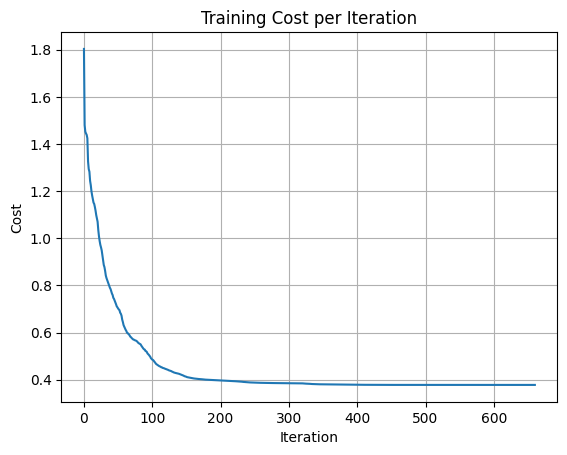

In [10]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Training Cost per Iteration")
plt.grid(True)
plt.show()

In [11]:
options={'maxfun': 1000}

In [12]:
# Make Predictions and Evaluate Accuracy

def predict(Theta1, Theta2, X):
    m = X.shape[0]
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    z2 = a1.dot(Theta1.T)
    a2 = np.concatenate([np.ones((m, 1)), sigmoid(z2)], axis=1)
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    
    # Pick the class with the highest probability
    return np.argmax(a3, axis=1)


In [13]:
# Predict on training set
y_pred_train = predict(Theta1, Theta2, X_train)
train_accuracy = np.mean(y_pred_train == y_train) * 100

# Predict on test set
y_pred_test = predict(Theta1, Theta2, X_test)
test_accuracy = np.mean(y_pred_test == y_test) * 100

# Print the results
print(f" Training Accuracy: {train_accuracy:.2f}%")
print(f" Test Accuracy: {test_accuracy:.2f}%")


 Training Accuracy: 96.89%
 Test Accuracy: 94.22%


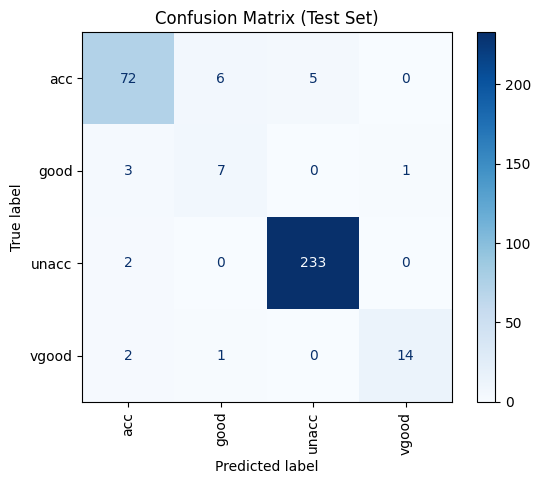

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_pred_test = predict(Theta1, Theta2, X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Get class labels from label encoder
class_labels = label_encoders["class"].classes_

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.savefig("confusion_matrix.png")
plt.show()